# STEP 1 - Imports e Setup Geral

In [1]:
# STEP 1 - Imports e Setup Geral
import math, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras import layers

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("TF version:", tf.__version__)


TF version: 2.16.2


# STEP 2 - Carregar e Preparar Dados

In [2]:
# STEP 2 - Carregar e Preparar Dados
DATA_PATH = Path("../processed_data/SPY_data_processed.parquet")
df_raw = pd.read_parquet(DATA_PATH)

# Se MultiIndex (ex: ('Close', 'SPY')), escolhe SPY
if isinstance(df_raw.columns, pd.MultiIndex):
    df = df_raw.xs("SPY", axis=1, level=-1)
else:
    df = df_raw.copy()

# Padroniza nomes para minúsculas
df.columns = [c.lower() for c in df.columns]

# Define colunas relevantes
TARGET_COL = "close"
FEATURES = ["close", "high", "low", "open", "volume"]

df = df[FEATURES].copy().sort_index()
print(df.head())


                 close        high         low        open     volume
Date                                                                 
2018-10-18  247.862961  251.154062  246.580608  250.553225  134557500
2018-10-19  247.728409  250.463499  247.028941  248.517557  139901600
2018-10-22  246.616501  248.723852  246.078443  248.401034   82415800
2018-10-23  245.360992  246.490912  240.877220  242.975649  146352700
2018-10-24  237.926987  245.495599  237.371003  245.109974  177806700


# STEP 3 - Funções auxiliares comuns (scaler, métricas, windowing)

In [3]:
# STEP 3 - Funções auxiliares comuns (scaler, métricas, windowing)

def make_scaler(kind: str):
    return MinMaxScaler() if kind == "minmax" else StandardScaler()

def inverse_transform(vec_scaled, sc):
    return sc.inverse_transform(vec_scaled.reshape(-1, 1)).ravel()

def metrics_report(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

def make_windowed_ds(df_in, features, target, lookback, horizon, sx, sy):
    Xv = df_in[features].astype(np.float32).values
    yv = df_in[[target]].astype(np.float32).values
    Xs, ys = sx.transform(Xv), sy.transform(yv)
    X, y = [], []
    for i in range(lookback, len(df_in) - horizon + 1):
        X.append(Xs[i - lookback:i, :])
        y.append(ys[i + horizon - 1, 0])
    return np.array(X, np.float32), np.array(y, np.float32).reshape(-1, 1)


# STEP 4 - Split Train / Val / Test + Scalers

In [4]:
# STEP 4 - Split Train / Val / Test + Scalers
LOOKBACK, HORIZON = 40, 1
SCALER_KIND = "minmax"

n_total = len(df)
train_end = int(n_total * 0.7)
val_end   = int(n_total * 0.85)

df_train, df_val, df_test = df.iloc[:train_end], df.iloc[train_end:val_end], df.iloc[val_end:]

scaler_x, scaler_y = make_scaler(SCALER_KIND), make_scaler(SCALER_KIND)
scaler_x.fit(df_train[FEATURES])
scaler_y.fit(df_train[[TARGET_COL]])

X_tr, y_tr = make_windowed_ds(df_train, FEATURES, TARGET_COL, LOOKBACK, HORIZON, scaler_x, scaler_y)
X_va, y_va = make_windowed_ds(df_val,   FEATURES, TARGET_COL, LOOKBACK, HORIZON, scaler_x, scaler_y)
X_te, y_te = make_windowed_ds(df_test,  FEATURES, TARGET_COL, LOOKBACK, HORIZON, scaler_x, scaler_y)

print("Shapes:", X_tr.shape, X_va.shape, X_te.shape)


Shapes: (1189, 40, 5) (224, 40, 5) (224, 40, 5)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feat

# STEP 5 — WINDOWING (Transforma série temporal em amostras X/y)

In [5]:
# ===============================================================
# STEP 5 — WINDOWING (Transforma série temporal em amostras X/y)
# - Constrói janelas deslizantes de tamanho LOOKBACK para prever D+HORIZON.
# - X tem shape: (n_amostras, LOOKBACK, n_features)
# - y tem shape: (n_amostras, 1)
# ===============================================================

import numpy as np

def make_windowed_ds(
    df_in,                # DataFrame com índice temporal
    features,             # lista de colunas de entrada (ex.: ["close","high","low","open","volume"])
    target,               # coluna alvo (ex.: "close")
    lookback: int = 40,   # tamanho da janela (dias para trás)
    horizon: int = 1,     # passos à frente (D+1)
    scaler_x=None,        # scaler já "fitado" no treino (features)
    scaler_y=None         # scaler já "fitado" no treino (target)
):
    # 1) extrai arrays em float32
    Xv = df_in[features].astype(np.float32).values
    yv = df_in[[target]].astype(np.float32).values

    # 2) aplica escala (usando os scalers já ajustados no STEP 4)
    Xs = scaler_x.transform(Xv) if scaler_x is not None else Xv
    ys = scaler_y.transform(yv) if scaler_y is not None else yv

    # 3) monta janelas deslizantes
    X_list, y_list = [], []
    for i in range(lookback, len(df_in) - horizon + 1):
        X_list.append(Xs[i - lookback:i, :])   # janela [i-lookback, i)
        y_list.append(ys[i + horizon - 1, 0])  # alvo no instante futuro

    # 4) empacota
    X = np.array(X_list, dtype=np.float32)             # (N, LOOKBACK, n_features)
    y = np.array(y_list, dtype=np.float32).reshape(-1, 1)  # (N, 1)
    return X, y

# ---- Criação das janelas para cada split (usa scalers do STEP 4) ----
X_tr, y_tr = make_windowed_ds(df_train, FEATURES, TARGET_COL, LOOKBACK, HORIZON, scaler_x, scaler_y)
X_va, y_va = make_windowed_ds(df_val,   FEATURES, TARGET_COL, LOOKBACK, HORIZON, scaler_x, scaler_y)
X_te, y_te = make_windowed_ds(df_test,  FEATURES, TARGET_COL, LOOKBACK, HORIZON, scaler_x, scaler_y)

print("Shapes -> X_tr:", X_tr.shape, " | X_va:", X_va.shape, " | X_te:", X_te.shape)
assert len(X_tr) and len(X_va) and len(X_te), "Janelas insuficientes — ajuste LOOKBACK/HORIZON ou split."


Shapes -> X_tr: (1189, 40, 5)  | X_va: (224, 40, 5)  | X_te: (224, 40, 5)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feat

# STEP 6 - Definição do modelo LSTM

In [6]:
# STEP 6 - Definição do modelo LSTM
def build_model(arch, input_shape, hidden, dropout, lr):
    inp = keras.Input(shape=input_shape)
    if arch == "lstm":
        x = layers.LSTM(hidden)(inp)
    elif arch == "stacked":
        x = layers.LSTM(hidden, return_sequences=True)(inp)
        x = layers.Dropout(dropout)(x)
        x = layers.LSTM(hidden // 2)(x)
    elif arch == "bilstm":
        x = layers.Bidirectional(layers.LSTM(hidden))(inp)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1)(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss="mse", metrics=["mae"])
    return model


# STEP 7 - Treino do modelo

In [7]:
# STEP 7 - Treino do modelo
ARCH, HIDDEN, DROPOUT, LR = "lstm", 128, 0.2, 1e-3
EPOCHS, BATCH = 100, 64

model = build_model(ARCH, (LOOKBACK, len(FEATURES)), HIDDEN, DROPOUT, LR)

ckpt_path = ARTIFACTS_DIR / "temp_best.keras"
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=str(ckpt_path), monitor="val_loss", save_best_only=True)
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=EPOCHS,
    batch_size=BATCH,
    verbose=1,
    callbacks=callbacks
)
model = keras.models.load_model(ckpt_path)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1345 - mae: 0.2709 - val_loss: 0.0553 - val_mae: 0.2291
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0064 - mae: 0.0619 - val_loss: 0.0212 - val_mae: 0.1387
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0044 - mae: 0.0504 - val_loss: 0.0074 - val_mae: 0.0778
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040 - mae: 0.0480 - val_loss: 0.0044 - val_mae: 0.0585
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0036 - mae: 0.0446 - val_loss: 0.0030 - val_mae: 0.0475
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029 - mae: 0.0408 - val_loss: 0.0027 - val_mae: 0.0454
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0031 - mae: 0.0411 - val_loss: 0.0037 - val_mae: 0.0542
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0026 - mae: 0.0382 - val_loss: 0.0030 - val_mae: 0.0489
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - lo

# STEP 8 - Avaliação do modelo

{'MAE': 8.2157135, 'RMSE': 10.312599505320126, 'MAPE': 1.3875690288841724}


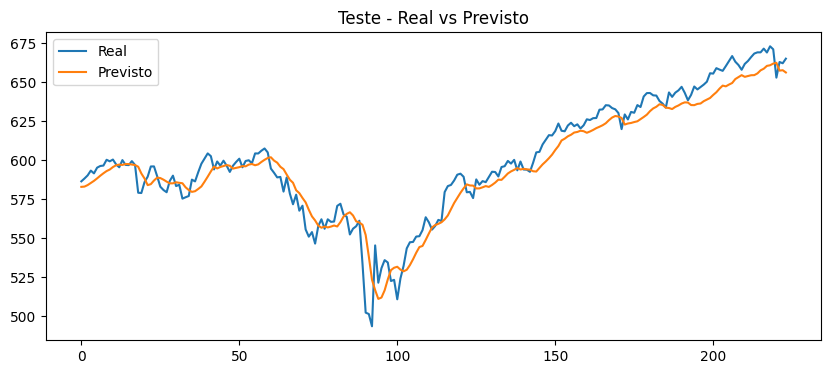

In [8]:
# STEP 8 - Avaliação do modelo
y_pred_scaled = model.predict(X_te, verbose=0).ravel()
y_pred = inverse_transform(y_pred_scaled, scaler_y)
y_true = inverse_transform(y_te.ravel(), scaler_y)

metrics = metrics_report(y_true, y_pred)
print(metrics)

plt.figure(figsize=(10,4))
plt.plot(y_true, label="Real")
plt.plot(y_pred, label="Previsto")
plt.title("Teste - Real vs Previsto")
plt.legend(); plt.show()


# STEP 9 — LOOP DE CENÁRIOS (MINI-GRID)

In [15]:
# ===============================================================
# STEP 9 — LOOP DE CENÁRIOS (MINI-GRID) COM MLFLOW (robusto)
# - Registra cada cenário como um run no MLflow
# - Converte SEMPRE métricas/params para tipos nativos (float/int/str)
# - Usa mlflow.log_dict para evitar erros de serialização
# ===============================================================

import os, math, json
import joblib, numpy as np, pandas as pd
from pathlib import Path
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import mlflow

# ---------- Helper universal p/ serialização ----------
def to_native(obj):
    import numpy as np, pandas as pd
    from pathlib import Path
    if isinstance(obj, (np.floating, np.integer)): return obj.item()
    if isinstance(obj, np.ndarray): return obj.tolist()
    if isinstance(obj, (pd.Timestamp, pd.Timedelta)): return obj.isoformat()
    if isinstance(obj, (pd.Series, pd.Index)): return obj.tolist()
    if isinstance(obj, Path): return str(obj)
    if isinstance(obj, dict): return {k: to_native(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)): return [to_native(v) for v in obj]
    return obj

# (opcional) aponte para um tracking server/dir específico
os.environ["MLFLOW_TRACKING_URI"] = "http://localhost:5000"  # ou deixe vazio p/ ./mlruns
mlflow.set_experiment("lstm-spy-grid")

ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR   = ARTIFACTS_DIR / "reports"; REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# ---- 9.1 Espaço de busca ----
FEATURES_LIST = [
    FEATURES,          # multivariado atual
    [TARGET_COL],      # univariado (baseline)
]
LOOKBACK_LIST = [40, 60]
ARCH_LIST     = ["lstm", "stacked"]
LR_LIST       = [1e-3, 5e-4]
HIDDEN_LIST   = [64, 128]
DROPOUT_LIST  = [0.2]
SCALERS       = ["minmax"]  # adicione "standard" se quiser

# ---- 9.2 Helpers ----
def make_scaler(kind: str):
    return MinMaxScaler() if kind == "minmax" else StandardScaler()

def inverse_transform(vec_scaled, sc):
    return sc.inverse_transform(vec_scaled.reshape(-1,1)).ravel()

def metrics_report(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100.0)
    # retorna já como tipos nativos
    return {"MAE": float(mae), "RMSE": float(rmse), "MAPE": float(mape)}

def train_once(cfg):
    """Treina/avalia 1 cenário e retorna (linha_de_métricas_nativa, artefatos|None)."""
    feats, lb, arch = cfg["features"], int(cfg["lookback"]), str(cfg["arch"])
    lr, hidden, dropout = float(cfg["lr"]), int(cfg["hidden"]), float(cfg["dropout"])
    scalerk, horizon = str(cfg["scaler"]), int(cfg["horizon"])
    epochs, batch = int(cfg["epochs"]), int(cfg["batch"])

    # 1) Fit scalers NO TREINO desta configuração
    sx, sy = make_scaler(scalerk), make_scaler(scalerk)
    sx.fit(df_train[feats].astype(np.float32).values)
    sy.fit(df_train[[TARGET_COL]].astype(np.float32).values)

    # 2) Windowing por split
    X_tr, y_tr = make_windowed_ds(df_train, feats, TARGET_COL, lb, horizon, sx, sy)
    X_va, y_va = make_windowed_ds(df_val,   feats, TARGET_COL, lb, horizon, sx, sy)
    X_te, y_te = make_windowed_ds(df_test,  feats, TARGET_COL, lb, horizon, sx, sy)
    if len(X_tr)==0 or len(X_va)==0 or len(X_te)==0:
        return None, None  # janela insuficiente

    # 3) Modelo
    model = build_model(arch, (lb, len(feats)), hidden, dropout, lr)

    # 4) Callbacks
    ckpt_tmp = ARTIFACTS_DIR / "grid_tmp.keras"
    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
        keras.callbacks.ModelCheckpoint(filepath=str(ckpt_tmp), monitor="val_loss", save_best_only=True),
    ]

    # 5) Treino
    model.fit(X_tr, y_tr, validation_data=(X_va, y_va),
              epochs=epochs, batch_size=batch, verbose=0, callbacks=callbacks)
    model = keras.models.load_model(ckpt_tmp)

    # 6) Avaliação (já retorna floats nativos)
    y_va_pred = inverse_transform(model.predict(X_va, verbose=0).ravel(), sy)
    y_va_true = inverse_transform(y_va.ravel(), sy)
    val_m = metrics_report(y_va_true, y_va_pred)

    y_te_pred = inverse_transform(model.predict(X_te, verbose=0).ravel(), sy)
    y_te_true = inverse_transform(y_te.ravel(), sy)
    test_m = metrics_report(y_te_true, y_te_pred)

    # 7) Linha já 100% nativa (sem np.float32)
    row = {
        "features": list(feats),
        "lookback": int(lb),
        "arch":     str(arch),
        "lr":       float(lr),
        "hidden":   int(hidden),
        "dropout":  float(dropout),
        "scaler":   str(scalerk),
        "horizon":  int(horizon),
        "epochs":   int(epochs),
        "batch":    int(batch),
        "val_MAE":  float(val_m["MAE"]),
        "val_RMSE": float(val_m["RMSE"]),
        "val_MAPE": float(val_m["MAPE"]),
        "test_MAE": float(test_m["MAE"]),
        "test_RMSE":float(test_m["RMSE"]),
        "test_MAPE":float(test_m["MAPE"]),
    }
    return row, {"model": model, "scaler_x": sx, "scaler_y": sy}

# ---- 9.3 Gera cenários ----
SCENARIOS = []
for feats in FEATURES_LIST:
    for lb in LOOKBACK_LIST:
        for arch in ARCH_LIST:
            for lr in LR_LIST:
                for hidden in HIDDEN_LIST:
                    for dropout in DROPOUT_LIST:
                        for scalerk in SCALERS:
                            SCENARIOS.append({
                                "features": feats,
                                "lookback": lb,
                                "arch": arch,
                                "lr": lr,
                                "hidden": hidden,
                                "dropout": dropout,
                                "scaler": scalerk,
                                "horizon": HORIZON,
                                "epochs": EPOCHS,
                                "batch": BATCH,
                            })

# ---- 9.4 Loop + MLflow ----
results, best = [], {"val_RMSE": float("inf")}
for i, cfg in enumerate(SCENARIOS, 1):
    with mlflow.start_run(run_name=f"scenario_{i}"):
        print(f"[{i}/{len(SCENARIOS)}] {cfg}")
        row, arts = train_once(cfg)
        if row is None:
            mlflow.set_tag("status", "skipped_window_too_short")
            continue

        # Params (hiperparâmetros e espaço do problema) — SEMPRE nativos
        mlflow.log_params({
            "features": ",".join([str(c) for c in row["features"]]),
            "lookback": int(row["lookback"]),
            "arch":     str(row["arch"]),
            "lr":       float(row["lr"]),
            "hidden":   int(row["hidden"]),
            "dropout":  float(row["dropout"]),
            "scaler":   str(row["scaler"]),
            "horizon":  int(row["horizon"]),
            "epochs":   int(row["epochs"]),
            "batch":    int(row["batch"]),
            "target":   TARGET_COL
        })

        # Métricas (val/test) — SEMPRE floats nativos
        mlflow.log_metrics({
            "val_MAE":  float(row["val_MAE"]),
            "val_RMSE": float(row["val_RMSE"]),
            "val_MAPE": float(row["val_MAPE"]),
            "test_MAE": float(row["test_MAE"]),
            "test_RMSE":float(row["test_RMSE"]),
            "test_MAPE":float(row["test_MAPE"])
        })

        # Tags de contexto
        mlflow.set_tags({
            "selection_criterion": "val_RMSE",
            "ticker": "SPY",
            "reason": "grid search para achar menor val_RMSE; teste apenas informativo",
            "environment": "notebook-vscode-mac"
        })

        # Artefato leve: sumário do cenário atual (sem arquivos temporários)
        mlflow.log_dict(to_native(row), f"scenario/scenario_{i}.json")

        # Acumula no relatório consolidado
        results.append(row)

        # Seleção do melhor por val_RMSE (não usa TEST)
        if row["val_RMSE"] < best["val_RMSE"]:
            best = {**row, "mlflow_run_id": mlflow.active_run().info.run_id}

            # salva artefatos locais do campeão (para uso posterior)
            best_model_path = ARTIFACTS_DIR / "best_model.keras"
            arts["model"].save(best_model_path)
            joblib.dump(arts["scaler_x"], ARTIFACTS_DIR / "scaler_x.joblib")
            joblib.dump(arts["scaler_y"], ARTIFACTS_DIR / "scaler_y.joblib")

            # também loga esses artefatos no run vencedor
            mlflow.log_artifact(str(best_model_path))
            mlflow.log_artifact(str(ARTIFACTS_DIR / "scaler_x.joblib"))
            mlflow.log_artifact(str(ARTIFACTS_DIR / "scaler_y.joblib"))

            # Escreve e loga summary do campeão
            summary = {
                **row,
                "model": str(best_model_path),
                "scaler_x": str(ARTIFACTS_DIR / "scaler_x.joblib"),
                "scaler_y": str(ARTIFACTS_DIR / "scaler_y.joblib")
            }
            # como arquivo local + artefato
            with open(ARTIFACTS_DIR / "summary.json", "w") as f:
                json.dump(to_native(summary), f, indent=2)
            mlflow.log_artifact(str(ARTIFACTS_DIR / "summary.json"))
            # e também direto como dict no run
            mlflow.log_dict(to_native(summary), "scenario/best_summary.json")

# ---- 9.5 Relatório consolidado + log no MLflow ----
res_df = pd.DataFrame(results).sort_values("val_RMSE").reset_index(drop=True)
grid_csv = REPORTS_DIR / "grid_search_results.csv"
res_df.to_csv(grid_csv, index=False)

print("\nArquivo de resultados:", grid_csv.resolve())
print("Modelo vencedor salvo em:", (ARTIFACTS_DIR / "best_model.keras").resolve())
print("\n=== MELHOR CENÁRIO (selecionado por val_RMSE) ===")
display(pd.DataFrame([best]))
print(json.dumps(to_native(best), indent=2))

# Loga o CSV do grid como um run "resumo" (opcional)
with mlflow.start_run(run_name="grid_summary"):
    mlflow.log_artifact(str(grid_csv))
    if "mlflow_run_id" in best:
        mlflow.set_tag("best_run_id", best["mlflow_run_id"])
    mlflow.set_tag("selection_criterion", "val_RMSE")
    mlflow.set_tag("ticker", "SPY")


[1/32] {'features': ['close', 'high', 'low', 'open', 'volume'], 'lookback': 40, 'arch': 'lstm', 'lr': 0.001, 'hidden': 64, 'dropout': 0.2, 'scaler': 'minmax', 'horizon': 1, 'epochs': 100, 'batch': 64}
[2/32] {'features': ['close', 'high', 'low', 'open', 'volume'], 'lookback': 40, 'arch': 'lstm', 'lr': 0.001, 'hidden': 128, 'dropout': 0.2, 'scaler': 'minmax', 'horizon': 1, 'epochs': 100, 'batch': 64}
[3/32] {'features': ['close', 'high', 'low', 'open', 'volume'], 'lookback': 40, 'arch': 'lstm', 'lr': 0.0005, 'hidden': 64, 'dropout': 0.2, 'scaler': 'minmax', 'horizon': 1, 'epochs': 100, 'batch': 64}
[4/32] {'features': ['close', 'high', 'low', 'open', 'volume'], 'lookback': 40, 'arch': 'lstm', 'lr': 0.0005, 'hidden': 128, 'dropout': 0.2, 'scaler': 'minmax', 'horizon': 1, 'epochs': 100, 'batch': 64}
[5/32] {'features': ['close', 'high', 'low', 'open', 'volume'], 'lookback': 40, 'arch': 'stacked', 'lr': 0.001, 'hidden': 64, 'dropout': 0.2, 'scaler': 'minmax', 'horizon': 1, 'epochs': 100, '

,features,lookback,arch,lr,hidden,dropout,scaler,horizon,epochs,batch,val_MAE,val_RMSE,val_MAPE,test_MAE,test_RMSE,test_MAPE,mlflow_run_id
0,"[close, high, low, open, volume]",60,lstm,0.0005,128,0.2,minmax,1,100,64,4.795666,6.298418,0.934647,6.984128,9.560717,1.20022,f0d952cc7f024e5d96157c9ffb9f2bf7


{
  "features": [
    "close",
    "high",
    "low",
    "open",
    "volume"
  ],
  "lookback": 60,
  "arch": "lstm",
  "lr": 0.0005,
  "hidden": 128,
  "dropout": 0.2,
  "scaler": "minmax",
  "horizon": 1,
  "epochs": 100,
  "batch": 64,
  "val_MAE": 4.795665740966797,
  "val_RMSE": 6.298418106810103,
  "val_MAPE": 0.9346470236778259,
  "test_MAE": 6.984128475189209,
  "test_RMSE": 9.560716649731091,
  "test_MAPE": 1.2002197094261646,
  "mlflow_run_id": "f0d952cc7f024e5d96157c9ffb9f2bf7"
}


# STEP 10 — TESTE FINAL

In [18]:
# ===============================================================
# STEP 10 — TESTE FINAL (com MLflow) — versão robusta p/ JSON
# ===============================================================

import os, math, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
import mlflow
import mlflow.keras

mlflow.set_experiment("lstm-spy-final")

REPORTS_DIR = ARTIFACTS_DIR / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)  # garante pasta

# ---------- helper universal p/ serialização ----------
def to_native(obj):
    import numpy as _np, pandas as _pd
    from pathlib import Path as _Path
    if isinstance(obj, (_np.floating, _np.integer)): return obj.item()
    if isinstance(obj, _np.ndarray): return obj.tolist()
    if isinstance(obj, (_pd.Timestamp, _pd.Timedelta)): return obj.isoformat()
    if isinstance(obj, (_pd.Series, _pd.Index)): return obj.tolist()
    if isinstance(obj, _Path): return str(obj)
    if isinstance(obj, dict): return {k: to_native(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)): return [to_native(v) for v in obj]
    return obj

# ---------- helpers ----------
def make_scaler(kind: str):
    return MinMaxScaler() if kind == "minmax" else StandardScaler()

def inverse_transform(vec_scaled: np.ndarray, sc):
    return sc.inverse_transform(vec_scaled.reshape(-1,1)).ravel()

def metrics_report(y_true: np.ndarray, y_pred: np.ndarray):
    mae  = float(mean_absolute_error(y_true, y_pred))
    rmse = float(math.sqrt(mean_squared_error(y_true, y_pred)))
    mape = float(np.mean(np.abs((y_true - y_pred) /
               np.clip(np.abs(y_true), 1e-8, None))) * 100.0)
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# ---------- 10.1 carregar melhor configuração ----------
best_cfg = {
    "features": list(best["features"]),
    "lookback": int(best["lookback"]),
    "arch":     str(best["arch"]),
    "lr":       float(best["lr"]),
    "hidden":   int(best["hidden"]),
    "dropout":  float(best["dropout"]),
    "scaler":   str(best["scaler"]),
    "horizon":  int(best["horizon"]),
    "epochs":   int(best["epochs"]),
    "batch":    int(best["batch"]),
}
print(">> Re-treinando com a melhor config do STEP 9:\n",
      json.dumps(best_cfg, indent=2))

# ---------- 10.2 juntar Train + Val e criar mini-val interna ----------
df_trval = pd.concat([df_train, df_val]).copy()
val_frac_inner = 0.10
split = max(int(len(df_trval) * (1 - val_frac_inner)),
            best_cfg["lookback"] + best_cfg["horizon"] + 1)
df_tr_inner = df_trval.iloc[:split]
df_vi_inner = df_trval.iloc[split:]

# ---------- 10.3 scalers ----------
sx = make_scaler(best_cfg["scaler"])
sy = make_scaler(best_cfg["scaler"])
sx.fit(df_tr_inner[best_cfg["features"]].astype(np.float32).values)
sy.fit(df_tr_inner[[TARGET_COL]].astype(np.float32).values)

# ---------- 10.4 windowing ----------
X_tr, y_tr = make_windowed_ds(df_tr_inner, best_cfg["features"], TARGET_COL,
                              best_cfg["lookback"], best_cfg["horizon"], sx, sy)
X_vi, y_vi = make_windowed_ds(df_vi_inner, best_cfg["features"], TARGET_COL,
                              best_cfg["lookback"], best_cfg["horizon"], sx, sy)
X_te, y_te = make_windowed_ds(df_test, best_cfg["features"], TARGET_COL,
                              best_cfg["lookback"], best_cfg["horizon"], sx, sy)
print("Shapes ->", X_tr.shape, X_vi.shape, X_te.shape)

# ===============================================================
# MLflow run principal — re-treino + teste final
# ===============================================================
with mlflow.start_run(run_name="final_retrain_test"):

    # ---------- params ----------
    mlflow.log_params({
        "features": ",".join(best_cfg["features"]),
        "lookback": best_cfg["lookback"],
        "arch": best_cfg["arch"],
        "lr": best_cfg["lr"],
        "hidden": best_cfg["hidden"],
        "dropout": best_cfg["dropout"],
        "scaler": best_cfg["scaler"],
        "horizon": best_cfg["horizon"],
        "epochs": best_cfg["epochs"],
        "batch": best_cfg["batch"],
        "target": TARGET_COL
    })

    # ---------- 10.5 construir e treinar modelo final ----------
    final_model = build_model(best_cfg["arch"],
                              (best_cfg["lookback"], len(best_cfg["features"])),
                              best_cfg["hidden"], best_cfg["dropout"], best_cfg["lr"])
    ckpt_final = ARTIFACTS_DIR / "final_temp.keras"
    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10,
                                      restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                          patience=5, min_lr=1e-6),
        keras.callbacks.ModelCheckpoint(filepath=str(ckpt_final),
                                        monitor="val_loss", save_best_only=True),
    ]
    history_final = final_model.fit(
        X_tr, y_tr,
        validation_data=(X_vi, y_vi),
        epochs=best_cfg["epochs"],
        batch_size=best_cfg["batch"],
        verbose=1,
        callbacks=callbacks
    )
    final_model = keras.models.load_model(ckpt_final)

    # ---------- 10.6 avaliação FINAL ----------
    y_te_pred_scaled = final_model.predict(X_te, verbose=0).ravel()
    y_te_true = inverse_transform(y_te.ravel(), sy)
    y_te_pred = inverse_transform(y_te_pred_scaled, sy)
    test_final = metrics_report(y_te_true, y_te_pred)
    print("\n=== MÉTRICAS FINAIS (TEST) ===", test_final)

    mlflow.log_metrics({
        "test_final_MAE": float(test_final["MAE"]),
        "test_final_RMSE": float(test_final["RMSE"]),
        "test_final_MAPE": float(test_final["MAPE"])
    })

    # ---------- gráficos ----------
    plt.figure(figsize=(10,4))
    plt.plot(y_te_true, label="Real")
    plt.plot(y_te_pred, label="Previsto (final)")
    plt.legend(); plt.tight_layout()
    plt.savefig(REPORTS_DIR / "test_real_vs_pred.png")
    plt.close()

    errors = y_te_true - y_te_pred
    plt.figure(figsize=(10,3))
    plt.plot(errors); plt.axhline(0, color='red', ls='--')
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / "test_residuos.png")
    plt.close()

    # ---------- 10.7 salvar artefatos ----------
    final_model_path = ARTIFACTS_DIR / "best_model_final.keras"
    final_sx_path    = ARTIFACTS_DIR / "scaler_x_final.joblib"
    final_sy_path    = ARTIFACTS_DIR / "scaler_y_final.joblib"

    final_model.save(final_model_path)
    joblib.dump(sx, final_sx_path)
    joblib.dump(sy, final_sy_path)

    summary_final = {
        "target": TARGET_COL,
        **best_cfg,                     # já normalizado para tipos nativos
        "test_final": test_final,       # já com floats nativos
        "model_final": str(final_model_path),
        "scaler_x_final": str(final_sx_path),
        "scaler_y_final": str(final_sy_path),
        "reason": "Menor val_RMSE no grid; passou teste final; resíduos sem viés."
    }

    # ① grava arquivo local SEM np.float32
    with open(ARTIFACTS_DIR / "summary_final.json", "w") as f:
        json.dump(to_native(summary_final), f, indent=2)

    # ② loga no MLflow diretamente como dict (mais seguro)
    mlflow.log_dict(to_native(summary_final), "summary_final.json")

    # ---------- logar artefatos no MLflow ----------
    mlflow.log_artifact(str(final_model_path))
    mlflow.log_artifact(str(final_sx_path))
    mlflow.log_artifact(str(final_sy_path))
    mlflow.log_artifact(str(REPORTS_DIR / "test_real_vs_pred.png"))
    mlflow.log_artifact(str(REPORTS_DIR / "test_residuos.png"))

    # registrar o modelo no Model Registry
    sample_input = np.zeros((1, best_cfg["lookback"], len(best_cfg["features"])),
                            dtype=np.float32)
    signature = mlflow.models.signature.infer_signature(
        sample_input, np.array([[0.0]], dtype=np.float32)
    )
    mlflow.keras.log_model(
        model=final_model,
        artifact_path="model",
        signature=signature,
        registered_model_name="LSTM-SPY"
    )

    mlflow.set_tags({
        "selection_criterion": "val_RMSE",
        "ticker": "SPY",
        "reason": "Menor val_RMSE no grid; re-treinado Train+Val; métricas finais registradas.",
        "environment": "notebook-vscode-mac",
        "grid_best_run_id": best.get("mlflow_run_id", "n/a")
    })


>> Re-treinando com a melhor config do STEP 9:
 {
  "features": [
    "close",
    "high",
    "low",
    "open",
    "volume"
  ],
  "lookback": 60,
  "arch": "lstm",
  "lr": 0.0005,
  "hidden": 128,
  "dropout": 0.2,
  "scaler": "minmax",
  "horizon": 1,
  "epochs": 100,
  "batch": 64
}
Shapes -> (1283, 60, 5) (90, 60, 5) (204, 60, 5)
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1777 - mae: 0.3303 - val_loss: 0.0299 - val_mae: 0.1698 - learning_rate: 5.0000e-04
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0085 - mae: 0.0691 - val_loss: 0.0018 - val_mae: 0.0364 - learning_rate: 5.0000e-04
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0040 - mae: 0.0497 - val_loss: 0.0051 - val_mae: 0.0659 - learning_rate: 5.0000e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0034 - mae: 0.0445 - val_loss: 0.0033 - val_mae: 0.0519 - learning_rate: 5.0000e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0032 - mae: 0.0

2025/11/07 20:36:46 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/ss/68mkcwd10hqbt1xsxshkfj440000gp/T/tmpseh2s6dz/model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'LSTM-SPY'.
2025/11/07 20:36:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM-SPY, version 1
Created version '1' of model 'LSTM-SPY'.


# STEP 11 — INFERÊNCIA (D+1 e multi-passos opcionais)

In [19]:
# ===============================================================
# STEP 11 — INFERÊNCIA (D+1 e multi-passos opcionais)
# - Carrega artefatos FINAIS do Step 10
# - Faz previsão D+1 usando a última janela real
# - (Opcional) Faz N passos à frente por recursão
# - Salva CSV com previsões
# ===============================================================

from tensorflow import keras
import joblib, numpy as np, pandas as pd
from datetime import datetime

# --- carregar artefatos finais ---
final_model = keras.models.load_model("artifacts/best_model_final.keras")
sx_final = joblib.load("artifacts/scaler_x_final.joblib")
sy_final = joblib.load("artifacts/scaler_y_final.joblib")

# --- configs do best_cfg vindas do Step 9 ---
FEATS = best_cfg["features"]
LB    = best_cfg["lookback"]
H     = best_cfg["horizon"]   # aqui usamos D+1, mas deixei genérico

# --- D+1 com última janela real ---
last_window = df[FEATS].iloc[-LB:].astype(np.float32).values
last_scaled = sx_final.transform(last_window).reshape(1, LB, len(FEATS))
y_next_scaled = final_model.predict(last_scaled, verbose=0).ravel()[0]
y_next = sy_final.inverse_transform([[y_next_scaled]]).ravel()[0]
print(f"Previsão D+{H} de {TARGET_COL}: {y_next:.4f}")

# --- (opcional) N passos à frente (recursivo simples) ---
def forecast_n_steps(df_in: pd.DataFrame, n_steps: int = 5):
    """
    Gera n passos à frente por recursão, alimentando as previsões no lugar da coluna alvo.
    Obs: usamos 'close' como alvo; para multivariado, assumimos que as demais features
    não são conhecidas no futuro (mantemos as últimas linhas como proxy).
    """
    hist = df_in[FEATS].copy().astype(np.float32)
    preds = []
    for _ in range(n_steps):
        window = hist.iloc[-LB:].values
        window_scaled = sx_final.transform(window).reshape(1, LB, len(FEATS))
        y_scaled = final_model.predict(window_scaled, verbose=0).ravel()[0]
        y_pred = sy_final.inverse_transform([[y_scaled]]).ravel()[0]
        preds.append(float(y_pred))
        # atualiza a série: substitui apenas a coluna alvo com o valor previsto
        new_row = hist.iloc[-1:].copy()  # clone do último registro como base
        new_row.iloc[0, new_row.columns.get_loc(TARGET_COL)] = y_pred
        hist = pd.concat([hist, new_row], axis=0)
    return preds

# exemplo de multi-passos:
multi_preds = forecast_n_steps(df, n_steps=5)
print("Próximas 5 previsões (recursivo):", [round(p, 4) for p in multi_preds])

# --- salvar CSV com previsões ---
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
pred_path = Path("artifacts/reports") / f"predictions_{ts}.csv"
pd.DataFrame({
    "last_date": [df.index[-1]],
    f"pred_D+{H}": [y_next],
    **{f"pred_D+{i+1}": [p] for i, p in enumerate(multi_preds)}
}).to_csv(pred_path, index=False)
print("Previsões salvas em:", pred_path.resolve())


Previsão D+1 de close: 666.0946
Próximas 5 previsões (recursivo): [666.0946, 666.017, 665.9852, 665.975, 665.9728]
Previsões salvas em: /Users/renanmelo/Documents/GitHub/FIAP/tc4/stock-prediction-lstm/notebooks/artifacts/reports/predictions_20251107_203709.csv


/var/folders/ss/68mkcwd10hqbt1xsxshkfj440000gp/T/ipykernel_9010/1800832903.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '666.0945822411695' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  new_row.iloc[0, new_row.columns.get_loc(TARGET_COL)] = y_pred


# STEP 12 — RELATÓRIOS & EXPORT

In [20]:
# ===============================================================
# STEP 12 — RELATÓRIOS & EXPORT
# - Consolida métricas finais
# - Gera gráficos úteis (loss, teste, resíduos)
# - Cria um "MODEL_CARD.md" com metadados e performance
# ===============================================================

import json, matplotlib.pyplot as plt
from pathlib import Path

ARTIFACTS_DIR = Path("artifacts/reports")

# --- (1) salvar métricas finais em JSON legível ---
final_metrics_path = ARTIFACTS_DIR / "metrics_final.json"
with open(final_metrics_path, "w") as f:
    json.dump(summary_final["test_final"], f, indent=2)
print("Métricas finais salvas em:", final_metrics_path.resolve())

# --- (2) gráficos prontos em arquivos PNG ---
# (a) histórico de loss do treino final
plt.figure(figsize=(7,4))
plt.plot(history_final.history["loss"], label="Treino")
plt.plot(history_final.history["val_loss"], label="Val interna")
plt.title("Evolução da perda (MSE)")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
loss_png = ARTIFACTS_DIR / "loss_curve_final.png"
plt.savefig(loss_png, dpi=120); plt.close()
print("Gráfico de loss salvo em:", loss_png.resolve())

# (b) real vs previsto no TESTE (já calculado no Step 9)
plt.figure(figsize=(10,4))
plt.plot(y_te_true, label="Real")
plt.plot(y_te_pred, label="Previsto")
plt.title("Teste Final — Real vs Previsto")
plt.legend(); plt.tight_layout()
rvp_png = ARTIFACTS_DIR / "test_real_vs_pred.png"
plt.savefig(rvp_png, dpi=120); plt.close()
print("Real vs Previsto salvo em:", rvp_png.resolve())

# (c) resíduos no TESTE
errors = y_te_true - y_te_pred
plt.figure(figsize=(10,3))
plt.plot(errors); plt.axhline(0, color="red", ls="--")
plt.title("Resíduos — Teste Final")
plt.tight_layout()
resid_png = ARTIFACTS_DIR / "test_residuos.png"
plt.savefig(resid_png, dpi=120); plt.close()
print("Resíduos salvos em:", resid_png.resolve())

# --- (3) Model Card simples (markdown) ---
model_card = f"""# Model Card — LSTM Forecast (D+{best_cfg['horizon']})

## Visão Geral
- **Alvo:** {TARGET_COL}
- **Features:** {', '.join(FEATS)}
- **Lookback:** {LB} dias
- **Arquitetura:** {best_cfg['arch']} (hidden={best_cfg['hidden']}, dropout={best_cfg['dropout']})
- **Scaler:** {best_cfg['scaler']}
- **Treino:** epochs={best_cfg['epochs']}, batch={best_cfg['batch']}, lr={best_cfg['lr']}

## Partições
- **Treino:** {len(df_train)} linhas
- **Validação:** {len(df_val)} linhas
- **Teste:** {len(df_test)} linhas

## Métricas Finais (Teste)
{json.dumps(summary_final["test_final"], indent=2)}
"""

# salvar o model card em artifacts
model_card_path = ARTIFACTS_DIR / "MODEL_CARD.md"
with open(model_card_path, "w", encoding="utf-8") as f:
    f.write(model_card)
print("Model card salvo em:", model_card_path.resolve())
# STEP 12 — RELATÓRIOS & EXPORT
# - Consolida métricas finais
# - Gera gráficos úteis (loss, teste, resíduos)
# - Cria um "MODEL_CARD.md" com metadados e performance
# ===============================================================

import json, matplotlib.pyplot as plt
from pathlib import Path

ARTIFACTS_DIR = Path("artifacts")

# --- (1) salvar métricas finais em JSON legível ---
final_metrics_path = ARTIFACTS_DIR / "metrics_final.json"
with open(final_metrics_path, "w") as f:
    json.dump(summary_final["test_final"], f, indent=2)
print("Métricas finais salvas em:", final_metrics_path.resolve())

# --- (2) gráficos prontos em arquivos PNG ---
# (a) histórico de loss do treino final
plt.figure(figsize=(7,4))
plt.plot(history_final.history["loss"], label="Treino")
plt.plot(history_final.history["val_loss"], label="Val interna")
plt.title("Evolução da perda (MSE)")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
loss_png = ARTIFACTS_DIR / "reports/loss_curve_final.png"
plt.savefig(loss_png, dpi=120); plt.close()
print("Gráfico de loss salvo em:", loss_png.resolve())

# (b) real vs previsto no TESTE (já calculado no Step 9)
plt.figure(figsize=(10,4))
plt.plot(y_te_true, label="Real")
plt.plot(y_te_pred, label="Previsto")
plt.title("Teste Final — Real vs Previsto")
plt.legend(); plt.tight_layout()
rvp_png = ARTIFACTS_DIR / "test_real_vs_pred.png"
plt.savefig(rvp_png, dpi=120); plt.close()
print("Real vs Previsto salvo em:", rvp_png.resolve())

# (c) resíduos no TESTE
errors = y_te_true - y_te_pred
plt.figure(figsize=(10,3))
plt.plot(errors); plt.axhline(0, color="red", ls="--")
plt.title("Resíduos — Teste Final")
plt.tight_layout()
resid_png = ARTIFACTS_DIR / "test_residuos.png"
plt.savefig(resid_png, dpi=120); plt.close()
print("Resíduos salvos em:", resid_png.resolve())

# --- (3) Model Card simples (markdown) ---
model_card = f"""# Model Card — LSTM Forecast (D+{best_cfg['horizon']})

## Visão Geral
- **Alvo:** {TARGET_COL}
- **Features:** {', '.join(FEATS)}
- **Lookback:** {LB} dias
- **Arquitetura:** {best_cfg['arch']} (hidden={best_cfg['hidden']}, dropout={best_cfg['dropout']})
- **Scaler:** {best_cfg['scaler']}
- **Treino:** epochs={best_cfg['epochs']}, batch={best_cfg['batch']}, lr={best_cfg['lr']}

## Partições
- **Treino:** {len(df_train)} linhas
- **Validação:** {len(df_val)} linhas
- **Teste:** {len(df_test)} linhas

## Métricas Finais (Teste)
{json.dumps(summary_final["test_final"], indent=2)}
"""

# salvar o model card em artifacts
model_card_path = ARTIFACTS_DIR / "MODEL_CARD.md"
with open(model_card_path, "w", encoding="utf-8") as f:
    f.write(model_card)
print("Model card salvo em:", model_card_path.resolve())

Métricas finais salvas em: /Users/renanmelo/Documents/GitHub/FIAP/tc4/stock-prediction-lstm/notebooks/artifacts/reports/metrics_final.json
Gráfico de loss salvo em: /Users/renanmelo/Documents/GitHub/FIAP/tc4/stock-prediction-lstm/notebooks/artifacts/reports/loss_curve_final.png
Real vs Previsto salvo em: /Users/renanmelo/Documents/GitHub/FIAP/tc4/stock-prediction-lstm/notebooks/artifacts/reports/test_real_vs_pred.png
Resíduos salvos em: /Users/renanmelo/Documents/GitHub/FIAP/tc4/stock-prediction-lstm/notebooks/artifacts/reports/test_residuos.png
Model card salvo em: /Users/renanmelo/Documents/GitHub/FIAP/tc4/stock-prediction-lstm/notebooks/artifacts/reports/MODEL_CARD.md
Métricas finais salvas em: /Users/renanmelo/Documents/GitHub/FIAP/tc4/stock-prediction-lstm/notebooks/artifacts/metrics_final.json
Gráfico de loss salvo em: /Users/renanmelo/Documents/GitHub/FIAP/tc4/stock-prediction-lstm/notebooks/artifacts/reports/loss_curve_final.png
Real vs Previsto salvo em: /Users/renanmelo/Docum